In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iterative-stratification/iterative-stratification-master/.gitignore
/kaggle/input/iterative-stratification/iterative-stratification-master/LICENSE
/kaggle/input/iterative-stratification/iterative-stratification-master/README.md
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.cfg
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.py
/kaggle/input/iterative-stratification/iterative-stratification-master/.travis.yml
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/__init__.py
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/test_ml_stratifiers.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/__init__.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/ml_stratifiers.py
/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/inpu

In [2]:
import sys
sys.path.insert(1, '/kaggle/input/iterative-stratification/iterative-stratification-master')

## Import Packages

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.layers import Input, Dense, Flatten, LeakyReLU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Add, Average
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_uniform
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils  import plot_model

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Helper Functions

In [4]:
def logloss_metric(df, y_true, y_pred):
    
    metrics = []
    
    # Calculate log_loss individually for every field
    for _target in df.columns:
        metrics.append(log_loss(y_true.loc[:, _target], 
                                y_pred.loc[:, _target].astype(float), 
                                labels=[0,1]))
    
    # Return mean of individual log_loss values
    return np.mean(metrics)

In [5]:
def logloss(y_true, y_pred):
    p_min = 0.001
    p_max = 1 - p_min
    y_pred = tf.clip_by_value(y_pred, p_min, p_max)
    return -backend.mean(y_true * backend.log(y_pred) + (1 - y_true) * backend.log(1 - y_pred))

In [6]:
def calculate_metric(data, seed, n_splits):
    diff_mean = []
    Fold = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    for n, (train_index, val_index) in enumerate(Fold.split(data, data)):
        train_mean_positivity = data.iloc[train_index, 1:].mean()
        val_mean_positivity = data.iloc[val_index, 1:].mean()
        diff = train_mean_positivity - val_mean_positivity
        diff_mean += [np.sqrt(np.sum(diff**2.))]
        
    mn = np.mean(diff_mean)
    std = np.std(diff_mean)
    return i, mn, std

In [7]:
def pca_fet(train, test, features, kind, n_components, SEED=10):
    
    # Combine train and test datasets
    train_ = train[features].copy()
    test_ = test[features].copy()
    data = pd.concat([train_, test_], axis=0)
    
    # Perform PCA to create new features
    pca = PCA(n_components=n_components, random_state=SEED)
    data = pca.fit_transform(data)
    columns = [f'pca_{kind}{i + 1}' for i in range(n_components)]
    data = pd.DataFrame(data, columns = columns)
    
    # Append new features to train and test datasets
    train_ = data.iloc[:train.shape[0]]
    test_ = data.iloc[train.shape[0]:].reset_index(drop=True)
    train = pd.concat([train, train_], axis=1)
    test = pd.concat([test, test_], axis=1)
    return train, test

In [8]:
def svd_fet(train, test, features, kind, n_components, SEED=10):
    
    # Combine train and test datasets
    train_ = train[features].copy()
    test_ = test[features].copy()
    data = pd.concat([train_, test_], axis=0)
    
    # Perform PCA to create new features
    svd = TruncatedSVD(n_components=n_components, random_state=SEED)
    data = svd.fit_transform(data)
    columns = [f'svd_{kind}{i + 1}' for i in range(n_components)]
    data = pd.DataFrame(data, columns = columns)
    
    # Append new features to train and test datasets
    train_ = data.iloc[:train.shape[0]]
    test_ = data.iloc[train.shape[0]:].reset_index(drop=True)
    train = pd.concat([train, train_], axis=1)
    test = pd.concat([test, test_], axis=1)
    return train, test

In [9]:
def kmeans_fet(train, test, features, kind, n_clusters, SEED=10):
    
    # Combine train and test datasets
    train_ = train[features].copy()
    test_ = test[features].copy()
    data = pd.concat([train_, test_], axis=0)
    
    # Perform KMeans to create new features
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED).fit(data)
    
    # Append new features to train and test datasets
    train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
    test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
    train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
    test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
    return train, test

In [10]:
def data_preprocess(dataset_dict, SEED=10):
    
    # Extract and load source datasets
    train_df = pd.read_csv(dataset_dict['train_dataset'])
    train_label_df = pd.read_csv(dataset_dict['train_labels_scored'])
    predict_df = pd.read_csv(dataset_dict['predict_dataset'])
    
    # Drop training rows with no MOA
    train_label_df = train_label_df.loc[train_df['cp_type']=='trt_cp'].reset_index(drop=True)
    train_df = train_df.loc[train_df['cp_type']=='trt_cp'].reset_index(drop=True)
    train_samples = train_df.shape[0]
    
    # Separate the columns for gene expression and cell viability
    features_g = [col for col in train_df.columns if col.startswith('g-')]
    features_c = [col for col in train_df.columns if col.startswith('c-')]
    
    # Quantile Transformer
    for col in (features_g + features_c):
        transformer = QuantileTransformer(n_quantiles=100, random_state=SEED, output_distribution="normal")
        vec_len = len(train_df[col].values)
        vec_len_test = len(predict_df[col].values)
        raw_vec = train_df[col].values.reshape(vec_len, 1)
        test_vec = predict_df[col].values.reshape(vec_len_test, 1)
        transformer.fit(raw_vec)
        train_df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
        predict_df[col] = transformer.transform(test_vec).reshape(1, vec_len_test)[0]
    
    # Generate PCA features
    train, test = pca_fet(train_df, predict_df, features_g, kind='g', n_components=480, SEED=SEED)
    train, test = pca_fet(train, test, features_c, kind='c', n_components=40, SEED=SEED)
    
    # Generate SVD features
    train, test = svd_fet(train, test, features_g, kind='g', n_components=480, SEED=SEED)
    train, test = svd_fet(train, test, features_c, kind='c', n_components=40, SEED=SEED)
    
    # Variance Threshold
    var_thresh = VarianceThreshold(0.8)
    data_raw = train.append(test, sort=False, ignore_index=True)
    data_transformed = var_thresh.fit_transform(data_raw.iloc[:, 4:])
    train_transformed = data_transformed[:train.shape[0]]
    test_transformed = data_transformed[-test.shape[0]:]
    
    train = pd.DataFrame(train[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),
                         columns=['sig_id','cp_type','cp_time','cp_dose'])
    train = pd.concat([train, pd.DataFrame(train_transformed)], axis=1)

    test = pd.DataFrame(test[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),
                        columns=['sig_id','cp_type','cp_time','cp_dose'])
    test = pd.concat([test, pd.DataFrame(test_transformed)], axis=1)
    
    # Generate KMeans features
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    train, test = kmeans_fet(train, test, features_g, kind='g', n_clusters=35, SEED=SEED)
    train, test = kmeans_fet(train, test, features_c, kind='c', n_clusters=5, SEED=SEED)
    
    # Combined both input dataframes
    combined_df = train.append(test, sort=False, ignore_index=True)
    
    # Feature Engineering
    combined_df['cp_type_enc'] = combined_df['cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    combined_df['cp_dose_enc'] = combined_df['cp_dose'].map({'D1': 0, 'D2': 1})
    combined_df['cp_time_days'] = combined_df['cp_time'].apply(lambda x: x//24)
    combined_df['g_sum'] = combined_df[features_g].sum(axis=1)
    combined_df['g_mean'] = combined_df[features_g].mean(axis=1)
    combined_df['g_std'] = combined_df[features_g].std(axis=1)
    combined_df['g_kurt'] = combined_df[features_g].kurtosis(axis=1)
    combined_df['g_skew'] = combined_df[features_g].skew(axis=1)
    combined_df['c_sum'] = combined_df[features_c].sum(axis=1)
    combined_df['c_mean'] = combined_df[features_c].mean(axis=1)
    combined_df['c_std'] = combined_df[features_c].std(axis=1)
    combined_df['c_kurt'] = combined_df[features_c].kurtosis(axis=1)
    combined_df['c_skew'] = combined_df[features_c].skew(axis=1)
    combined_df['gc_sum'] = combined_df[features_g + features_c].sum(axis=1)
    combined_df['gc_mean'] = combined_df[features_g + features_c].mean(axis=1)
    combined_df['gc_std'] = combined_df[features_g + features_c].std(axis=1)
    combined_df['gc_kurt'] = combined_df[features_g + features_c].kurtosis(axis=1)
    combined_df['gc_skew'] = combined_df[features_g + features_c].skew(axis=1)
    
    # Drop redundant columns
    combined_df.drop(['sig_id', 'cp_type', 'cp_dose', 'cp_time'], axis=1, inplace=True)
    train_label_df.drop(['sig_id'], axis=1, inplace=True)
    
    # Segregate train and predict datasets
    train_y = train_label_df.values
    train_x = combined_df[:train_samples].values
    predict_x = combined_df[train_samples:].values
    
    # Scaler for numerical values
    scaler = RobustScaler()
    train_x = scaler.fit_transform(train_x)
    predict_x = scaler.transform(predict_x)

    return train_x, train_y, predict_x

In [11]:
def moa_prediction_model(input_shape, output_shape):
    
    # Input Layers
    x_input = Input(shape=(input_shape, ))
    x_inp = BatchNormalization()(x_input)
    
    # Fully-connected Layers
    x1 = WeightNormalization(
            Dense(units=512, kernel_regularizer=l2(0.0001)))(x_inp)
    x1 = LeakyReLU()(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(rate=0.25)(x1)
    
    x2 = WeightNormalization(
            Dense(units=2048, kernel_regularizer=l2(0.001)))(x1)
    x2 = LeakyReLU()(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(rate=0.5)(x2)
    
    x2 = WeightNormalization(
            Dense(units=512, kernel_regularizer=l2(0.0001)))(x2)
    x2 = LeakyReLU()(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(rate=0.25)(x2)
    
    x3 = Add()([x1, x2])
    
    x4 = WeightNormalization(
            Dense(units=2048, kernel_regularizer=l2(0.001)))(x3)
    x4 = LeakyReLU()(x4)
    x4 = BatchNormalization()(x4)
    x4 = Dropout(rate=0.5)(x4)
    
    x4 = WeightNormalization(
            Dense(units=512, kernel_regularizer=l2(0.0001)))(x4)
    x4 = LeakyReLU()(x4)
    x4 = BatchNormalization()(x4)
    x4 = Dropout(rate=0.25)(x4)
    
    x5 = Average()([x1, x3, x4])
    x5 = BatchNormalization()(x5)
    
    x5 = WeightNormalization(
            Dense(units=512, kernel_regularizer=l2(0.0001)))(x5)
    x5 = LeakyReLU()(x5)
    x5 = BatchNormalization()(x5)
    x5 = Dropout(rate=0.25)(x5)
    
    # Output Layer
    x = WeightNormalization(
            Dense(units=output_shape, activation='sigmoid'))(x5)
    
    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='MOA_Prediction_Model')

    return model

## Data Preprocessing

### Set file paths for train and predict datasets

In [12]:
train_dataset = "/kaggle/input/lish-moa/train_features.csv"
train_labels_scored = "/kaggle/input/lish-moa/train_targets_scored.csv"
predict_dataset = "/kaggle/input/lish-moa/test_features.csv"

### Process train and predict features datasets

In [13]:
# Read and display individual dataframe shapes
train_df = pd.read_csv(train_dataset)
train_label_df = pd.read_csv(train_labels_scored)
predict_df = pd.read_csv(predict_dataset)

train_label_df.drop(['sig_id'], axis=1, inplace=True)

print("train_df: {}".format(train_df.shape))
print("train_label_df: {}".format(train_label_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (23814, 876)
train_label_df: (23814, 206)
predict_df: (3982, 876)


In [14]:
datasets = {}
datasets['train_dataset'] = train_dataset
datasets['train_labels_scored'] = train_labels_scored
datasets['predict_dataset'] = predict_dataset

In [15]:
Xtrain, Ytrain, Xpredict = data_preprocess(datasets)

print("Xtrain: {}".format(Xtrain.shape))
print("Ytrain: {}".format(Ytrain.shape))
print("Xpredict: {}".format(Xpredict.shape))

Xtrain: (21948, 1266)
Ytrain: (21948, 206)
Xpredict: (3982, 1266)


## Build and validate the model

In [16]:
# Define the model hyperparameters
mini_batch_size = 128

# Prediction Clipping Thresholds
p_min = 0.001
p_max = 1 - p_min

# Create the model
model = moa_prediction_model(Xtrain.shape[1], Ytrain.shape[1])
model.summary()

Model: "MOA_Prediction_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1266)]       0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1266)         5064        input_1[0][0]                    
__________________________________________________________________________________________________
weight_normalization (WeightNor (None, 512)          1297921     batch_normalization[0][0]        
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512)          0           weight_normalization[0][0]       
_______________________________________________________________________________

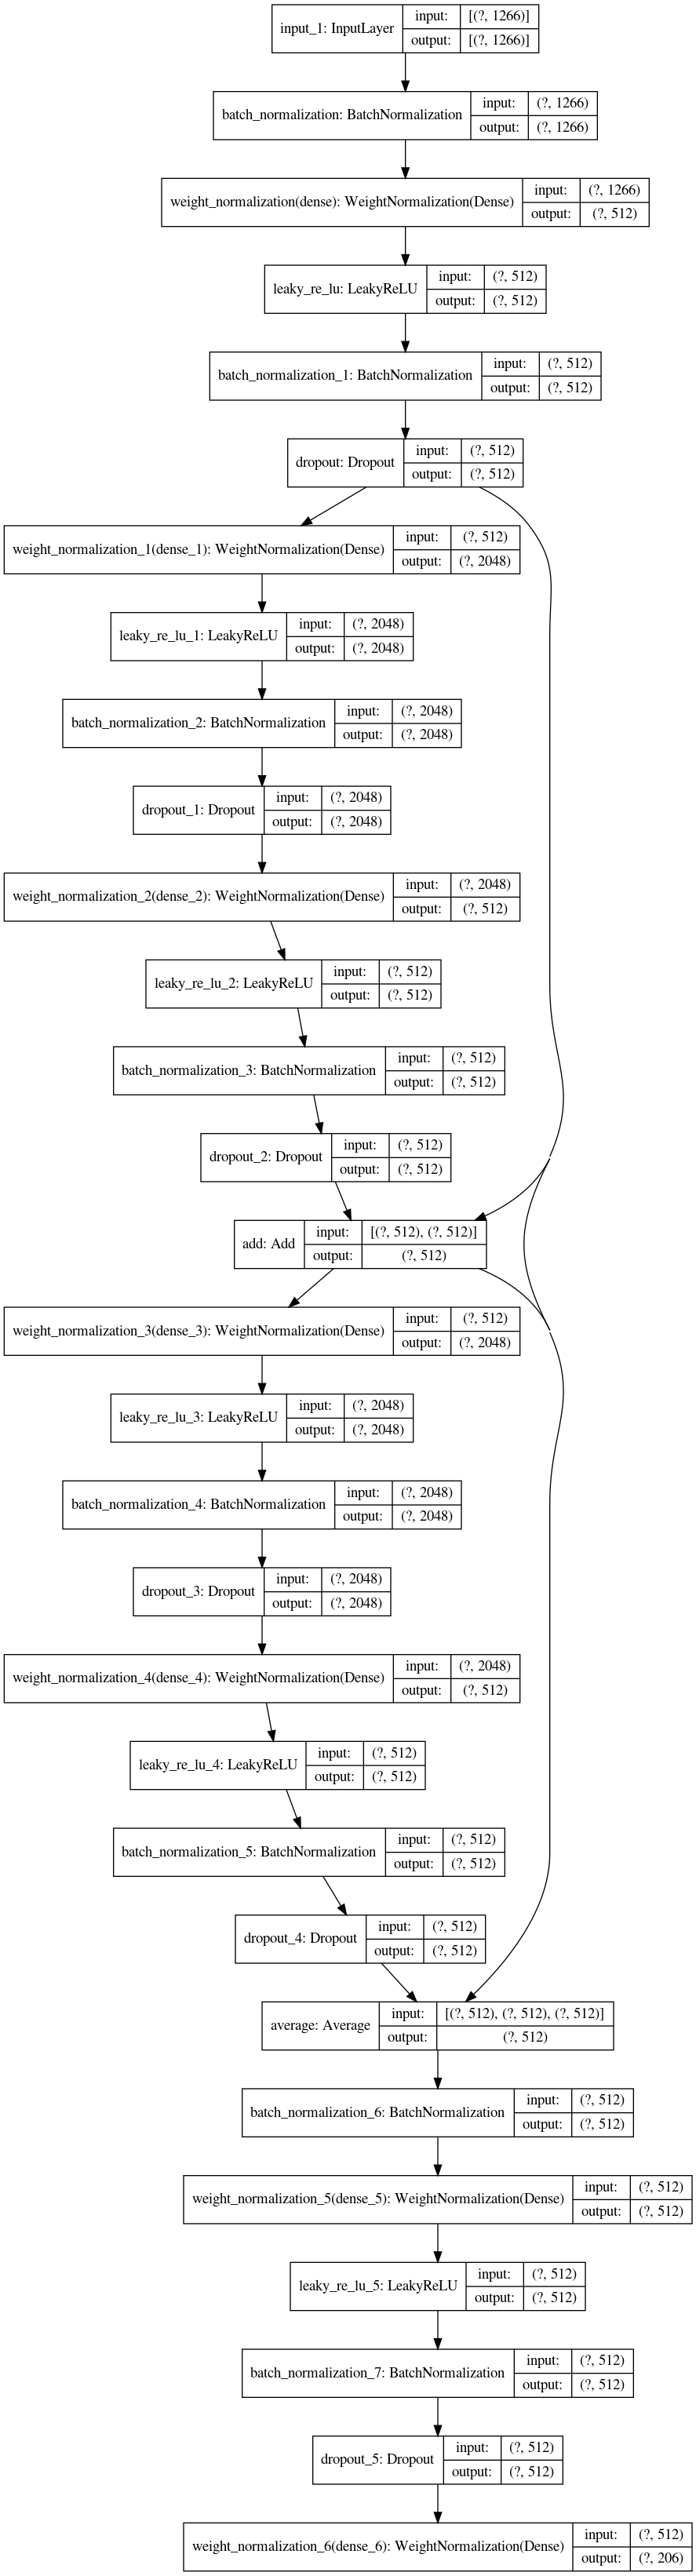

In [17]:
plot_model(model, to_file='/kaggle/working/moa_prediction_model.png', show_shapes=True, show_layer_names=True)

In [18]:
# Set number of K-Folds
FOLD = 10

# Set seeds for model training
seeds = [29, 93, 15, 9, 28]

val_metric = 0
y_pred_final = 0
idx = 0

for seed in seeds:
    seed_metric = 0
    
    # Define K-fold cross validation test harness
    kfold = MultilabelStratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)
    
    for i, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):

        idx += 1
        print("\n---------------- Fold {} ----------------".format(idx))

        train_x_tmp, val_x_tmp = Xtrain[train], Xtrain[val]
        train_y_tmp, val_y_tmp = Ytrain[train], Ytrain[val]

        # Create the model
        model = moa_prediction_model(Xtrain.shape[1], Ytrain.shape[1])

        # Compile model to configure the learning process
        model.compile(loss=BinaryCrossentropy(label_smoothing=p_min), 
                      metrics=logloss,
                      optimizer=Lookahead(AdamW(lr=1e-2, 
                                                weight_decay=1e-5, 
                                                clipvalue=700), 
                                          sync_period=10))

        # Early stopping policy
        early = EarlyStopping(monitor="val_logloss", mode="min", 
                              restore_best_weights=True, 
                              patience=10, verbose=0)

        # Reduce LR on plateau policy
        reduce_lr = ReduceLROnPlateau(monitor="val_logloss", factor=0.1, 
                                      min_lr=1e-5, patience=5, 
                                      verbose=0, mode='min')
        
        # Fit the model
        history = model.fit(x=train_x_tmp, y=train_y_tmp, 
                            batch_size=mini_batch_size, epochs=85, verbose=0,
                            callbacks=[reduce_lr, early], workers=5,
                            validation_data=(val_x_tmp, val_y_tmp))

        # Get logloss metric on validation dataset
        y_pred = model.predict(val_x_tmp)
        y_pred = np.clip(y_pred, p_min, p_max)
        true_labels = pd.DataFrame(val_y_tmp, columns=train_label_df.columns)
        pred_labels = pd.DataFrame(y_pred, columns=train_label_df.columns)
        metric = logloss_metric(train_label_df, true_labels, pred_labels)
        val_metric += metric
        seed_metric += metric
        
        # Make predictions
        pred_final = model.predict(Xpredict)
        y_pred_final += pred_final
        print("Seed: {} | Fold: {} | Log Loss: {}".format(seed, (i+1), metric))
    
    print("\nSeed: {} | Aggregate Log Loss: {}".format(seed, (seed_metric / FOLD)))
    print("--------------------------------------------------------------------\n")

print("Total #iterations: {}".format(idx))
val_metric /= float(idx)
y_pred_final /= float(idx)
print("Validation Logloss Metric: {}".format(val_metric))


---------------- Fold 1 ----------------
Seed: 29 | Fold: 1 | Log Loss: 0.01639719482491159

---------------- Fold 2 ----------------
Seed: 29 | Fold: 2 | Log Loss: 0.016259184516519108

---------------- Fold 3 ----------------
Seed: 29 | Fold: 3 | Log Loss: 0.016246762906693565

---------------- Fold 4 ----------------
Seed: 29 | Fold: 4 | Log Loss: 0.01618200496183524

---------------- Fold 5 ----------------
Seed: 29 | Fold: 5 | Log Loss: 0.016845669310115094

---------------- Fold 6 ----------------
Seed: 29 | Fold: 6 | Log Loss: 0.01642044896227704

---------------- Fold 7 ----------------
Seed: 29 | Fold: 7 | Log Loss: 0.01621999344262635

---------------- Fold 8 ----------------
Seed: 29 | Fold: 8 | Log Loss: 0.016458556241675023

---------------- Fold 9 ----------------
Seed: 29 | Fold: 9 | Log Loss: 0.01624698619676052

---------------- Fold 10 ----------------
Seed: 29 | Fold: 10 | Log Loss: 0.016157448964207677

Seed: 29 | Aggregate Log Loss: 0.01634342503276212
-----------

## Create submission file

In [19]:
y_pred_final = np.clip(y_pred_final, p_min, p_max)
pred_labels = pd.DataFrame(y_pred_final, columns=train_label_df.columns)
pred_labels.loc[predict_df['cp_type']=='ctl_vehicle', train_label_df.columns] = 0
print(pred_labels.shape)
pred_labels.head()

(3982, 206)


,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0.001465,0.002520,0.003281,0.017515,0.024265,0.006381,0.003035,0.007318,0.001000,0.018256,...,0.001559,0.002051,0.007756,0.001000,0.001000,0.001159,0.001588,0.002289,0.004712,0.002043
1,0.001000,0.001000,0.002573,0.002488,0.001208,0.001787,0.004544,0.008672,0.010503,0.007496,...,0.001313,0.001322,0.002551,0.001000,0.014007,0.001000,0.003734,0.001850,0.004085,0.004713
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.001182,0.001202,0.003245,0.014463,0.017539,0.005065,0.005550,0.004059,0.001000,0.008907,...,0.001000,0.002112,0.004832,0.021893,0.005376,0.001000,0.001711,0.003165,0.001025,0.002515
4,0.002702,0.001678,0.002611,0.014503,0.013951,0.003900,0.006492,0.003042,0.001000,0.012463,...,0.001961,0.001000,0.003249,0.001000,0.001863,0.001323,0.001000,0.002768,0.001000,0.003300


In [20]:
submit_df = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")
submit_df.loc[:, submit_df.columns != 'sig_id'] = pred_labels
submit_df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001465,0.002520,0.003281,0.017515,0.024265,0.006381,0.003035,0.007318,0.001000,...,0.001559,0.002051,0.007756,0.001000,0.001000,0.001159,0.001588,0.002289,0.004712,0.002043
1,id_001897cda,0.001000,0.001000,0.002573,0.002488,0.001208,0.001787,0.004544,0.008672,0.010503,...,0.001313,0.001322,0.002551,0.001000,0.014007,0.001000,0.003734,0.001850,0.004085,0.004713
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.001182,0.001202,0.003245,0.014463,0.017539,0.005065,0.005550,0.004059,0.001000,...,0.001000,0.002112,0.004832,0.021893,0.005376,0.001000,0.001711,0.003165,0.001025,0.002515
4,id_0027f1083,0.002702,0.001678,0.002611,0.014503,0.013951,0.003900,0.006492,0.003042,0.001000,...,0.001961,0.001000,0.003249,0.001000,0.001863,0.001323,0.001000,0.002768,0.001000,0.003300


In [21]:
submit_df.to_csv("/kaggle/working/submission.csv", index=False)